In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
from scipy.stats import zscore
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import shap
import lime
from PyALE import ale
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

random_state = 1000

In [2]:
df = pd.read_csv('../data/rock_data.csv')

# handle missing values
if df.isnull().values.any():
    df.fillna(df.mean(), inplace=True)
    print('Missing values filled with mean.')

# detect and remove outliers

# drop highly correlated features
df.drop(['Orientation', 'Area', 'Perimeter','Median Height', 'Max Height', 'STD Height'], axis=1, inplace=True)
df.columns

Index(['Sample ID', 'Rock ID', 'Class', 'Axis Major Length',
       'Axis Minor Length', 'Mean Height', 'Mean Gradient', 'STD Gradient',
       'Gradient at Max', 'Weighted Hu Moment 1', 'Weighted Hu Moment 2',
       'Weighted Hu Moment 3', 'Weighted Hu Moment 4'],
      dtype='object')

In [3]:
X = df.iloc[:,3:].to_numpy(dtype=float)

def map_class_values(x):
    mapping = {12: 0, 58: 1, 34: 2}
    return mapping.get(x,None)

y = np.vectorize(map_class_values)(df['Class'].values)

In [4]:
# training:validation:testing = 60:20:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

In [5]:
model_names = ['KNN', 'SVC', 'RF', 'XGB', 'MLP']
models = [KNeighborsClassifier(), SVC(), RandomForestClassifier(), XGBClassifier(), MLPClassifier(max_iter=500)]
grid_params = [{'n_neighbors': [5, 10, 15, 20], 'weights': ['uniform', 'distance']}, {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid']}, {'n_estimators': [10, 100, 200], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2', None]}, {'max_depth': [3,5,7], 'n_estimators': [10, 100, 200], 'reg_lambda': [1e-3, 1, 1e3]}, {'hidden_layer_sizes': [(100,), (100,50), (100,50,100)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [1e-3, 1, 1e3]}]

KNN with {'n_neighbors': 15, 'weights': 'distance'} 
               precision    recall  f1-score   support

           0       0.79      0.85      0.82        88
           1       0.59      0.48      0.53        54
           2       0.76      0.79      0.77        76

    accuracy                           0.74       218
   macro avg       0.71      0.71      0.71       218
weighted avg       0.73      0.74      0.73       218




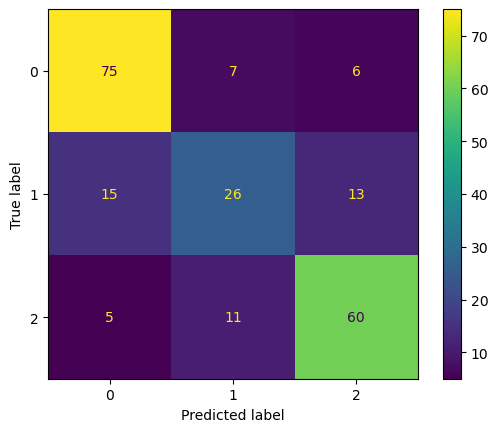

SVC with {'C': 10, 'kernel': 'rbf'} 
               precision    recall  f1-score   support

           0       0.76      0.81      0.78        88
           1       0.45      0.54      0.49        54
           2       0.80      0.63      0.71        76

    accuracy                           0.68       218
   macro avg       0.67      0.66      0.66       218
weighted avg       0.70      0.68      0.68       218




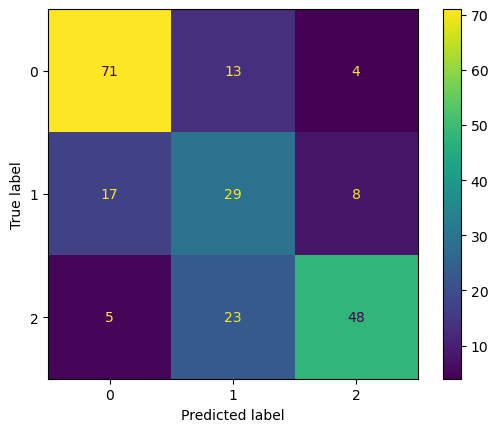

RF with {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 200} 
               precision    recall  f1-score   support

           0       0.78      0.83      0.81        88
           1       0.46      0.52      0.49        54
           2       0.77      0.64      0.70        76

    accuracy                           0.69       218
   macro avg       0.67      0.66      0.66       218
weighted avg       0.70      0.69      0.69       218




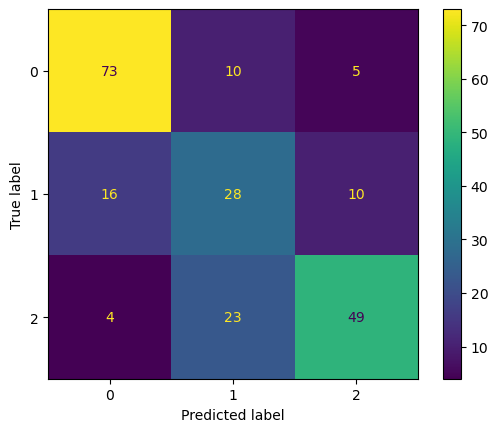

XGB with {'max_depth': 7, 'n_estimators': 100, 'reg_lambda': 0.001} 
               precision    recall  f1-score   support

           0       0.79      0.81      0.80        88
           1       0.44      0.54      0.48        54
           2       0.76      0.62      0.68        76

    accuracy                           0.67       218
   macro avg       0.66      0.65      0.65       218
weighted avg       0.69      0.67      0.68       218




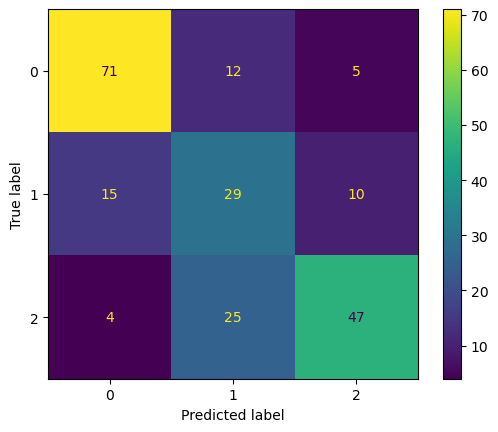

MLP with {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50, 100)} 
               precision    recall  f1-score   support

           0       0.77      0.76      0.77        88
           1       0.50      0.41      0.45        54
           2       0.75      0.86      0.80        76

    accuracy                           0.71       218
   macro avg       0.67      0.67      0.67       218
weighted avg       0.70      0.71      0.70       218




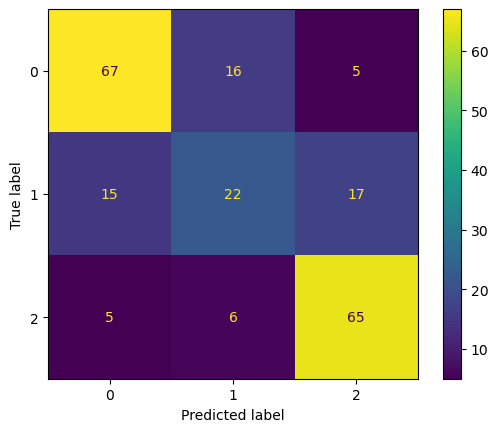

In [6]:
for m,model in enumerate(models):
    grid_search = GridSearchCV(model, grid_params[m], cv=5)
    grid_search.fit(X_train, y_train)
    model_best = grid_search.best_estimator_
    model_best_pred = model_best.predict(X_val)
    print(f'{model_names[m]} with {grid_search.best_params_} \n {classification_report(y_val, model_best_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_val, model_best_pred)).plot()
    show()

In [7]:
search_spaces = [{
    'n_neighbors': Integer(3,50),
    'weights': Categorical(['uniform', 'distance'])
    },
    
    {
    'C': Real(0.1, 10, 'log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'sigmoid']),
    },
    
    {
    'n_estimators': Integer(10,200),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'max_features': Categorical(['sqrt', 'log2', None]),
    },
    
    {
    'max_depth': Integer(3,10),
    'n_estimators': Integer(10,200),
    'reg_lambda': Real(1e-3, 1e3, 'log-uniform'),
    }
    ]

KNN with OrderedDict([('n_neighbors', 13), ('weights', 'uniform')]) 
               precision    recall  f1-score   support

           0       0.77      0.84      0.80        88
           1       0.51      0.46      0.49        54
           2       0.78      0.75      0.77        76

    accuracy                           0.72       218
   macro avg       0.69      0.68      0.68       218
weighted avg       0.71      0.72      0.71       218




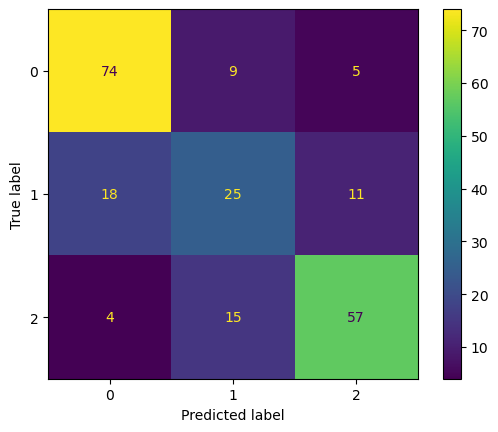

SVC with OrderedDict([('C', 5.729686551289536), ('kernel', 'rbf')]) 
               precision    recall  f1-score   support

           0       0.76      0.82      0.79        88
           1       0.44      0.50      0.47        54
           2       0.79      0.64      0.71        76

    accuracy                           0.68       218
   macro avg       0.66      0.65      0.66       218
weighted avg       0.69      0.68      0.68       218




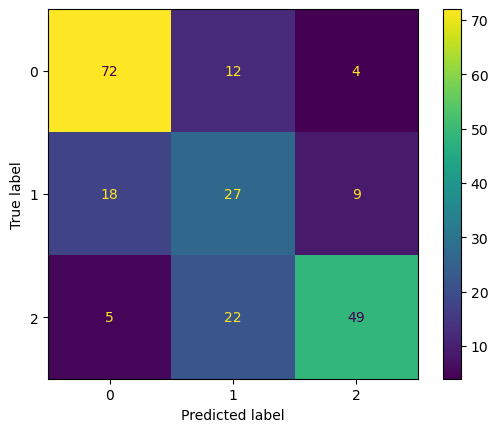

RF with OrderedDict([('criterion', 'log_loss'), ('max_features', 'log2'), ('n_estimators', 178)]) 
               precision    recall  f1-score   support

           0       0.78      0.83      0.80        88
           1       0.46      0.52      0.49        54
           2       0.79      0.66      0.72        76

    accuracy                           0.69       218
   macro avg       0.68      0.67      0.67       218
weighted avg       0.70      0.69      0.70       218




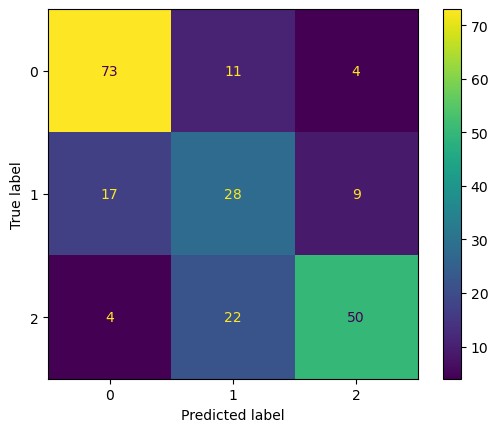

XGB with OrderedDict([('max_depth', 10), ('n_estimators', 190), ('reg_lambda', 10.94998894807248)]) 
               precision    recall  f1-score   support

           0       0.80      0.82      0.81        88
           1       0.48      0.56      0.52        54
           2       0.79      0.68      0.73        76

    accuracy                           0.71       218
   macro avg       0.69      0.69      0.69       218
weighted avg       0.72      0.71      0.71       218




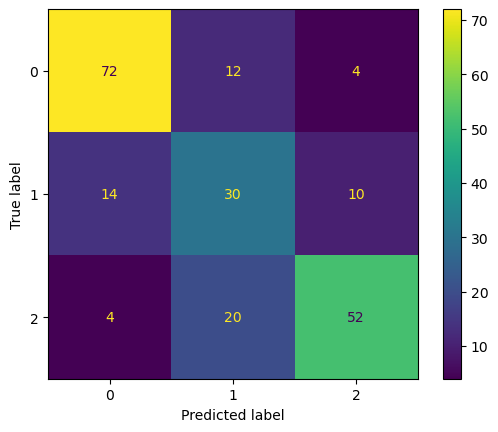

In [8]:
for m,model in enumerate(models[:-1]):
    bayes_search = BayesSearchCV(model, search_spaces[m], n_iter=50, cv=5, n_jobs=-1)
    bayes_search.fit(X_train, y_train)
    model_best = bayes_search.best_estimator_
    model_best_pred = model_best.predict(X_val)
    print(f'{model_names[m]} with {bayes_search.best_params_} \n {classification_report(y_val, model_best_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_val, model_best_pred)).plot()
    show()

In [9]:
best_models = [KNeighborsClassifier(n_neighbors=15, weights= 'distance'), SVC(C=10, kernel='rbf'), RandomForestClassifier(criterion='gini', max_features= 'log2', n_estimators=200), XGBClassifier(max_depth=3, n_estimators=101, reg_lambda=35.2), MLPClassifier(max_iter=500, activation='logistic', alpha=0.001, hidden_layer_sizes=(100,50,100))]

KNeighborsClassifier(n_neighbors=15, weights='distance') 
               precision    recall  f1-score   support

           0       0.72      0.84      0.77        74
           1       0.59      0.53      0.56        68
           2       0.72      0.67      0.69        76

    accuracy                           0.68       218
   macro avg       0.68      0.68      0.68       218
weighted avg       0.68      0.68      0.68       218




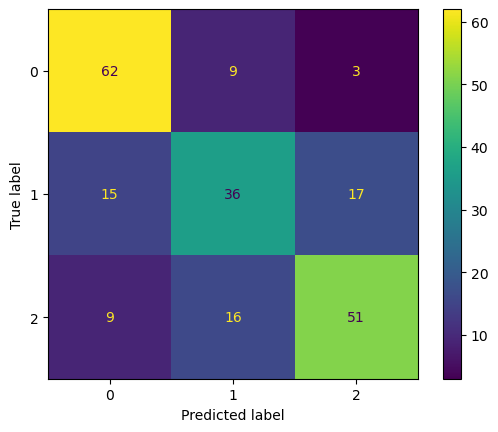

SVC(C=10) 
               precision    recall  f1-score   support

           0       0.70      0.86      0.78        74
           1       0.59      0.51      0.55        68
           2       0.75      0.67      0.71        76

    accuracy                           0.69       218
   macro avg       0.68      0.68      0.68       218
weighted avg       0.69      0.69      0.68       218




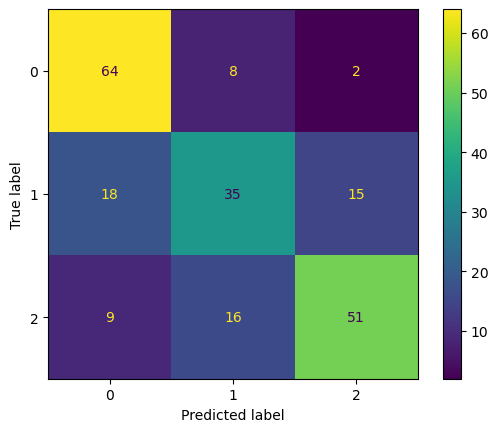

RandomForestClassifier(max_features='log2', n_estimators=200) 
               precision    recall  f1-score   support

           0       0.73      0.86      0.79        74
           1       0.59      0.56      0.58        68
           2       0.76      0.66      0.70        76

    accuracy                           0.70       218
   macro avg       0.69      0.69      0.69       218
weighted avg       0.70      0.70      0.69       218




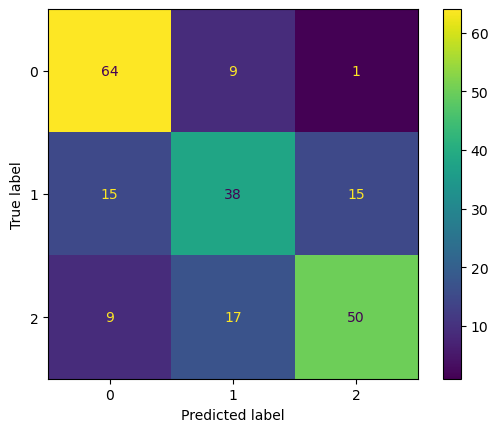

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=101, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...) 
               precision    recall  f1-score   support

           0       0.71      0.82      0.76        74
           1       0.56      0.56      0.56        68
           2       0.75      0.63      0.69        76

    accuracy          

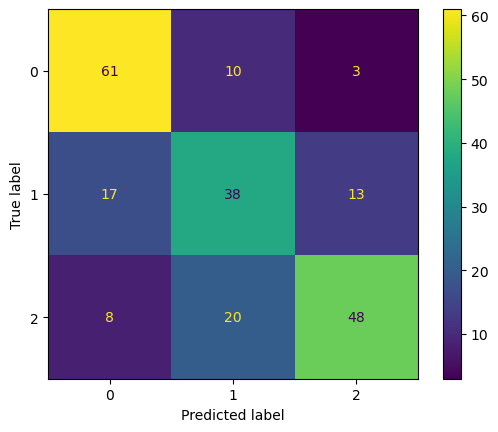

MLPClassifier(activation='logistic', alpha=0.001,
              hidden_layer_sizes=(100, 50, 100), max_iter=500) 
               precision    recall  f1-score   support

           0       0.74      0.86      0.80        74
           1       0.65      0.53      0.59        68
           2       0.74      0.74      0.74        76

    accuracy                           0.72       218
   macro avg       0.71      0.71      0.71       218
weighted avg       0.71      0.72      0.71       218




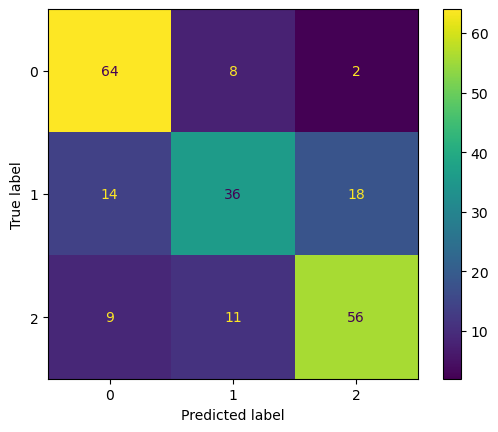

In [10]:
for m,model in enumerate(best_models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{model} \n {classification_report(y_test, y_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    show()

In [11]:
best_model = RandomForestClassifier(criterion='gini', max_features= 'log2', n_estimators=200)
best_model_cal_iso = CalibratedClassifierCV(best_model, method='isotonic')
best_model_cal_sig = CalibratedClassifierCV(best_model, method='sigmoid')
models = [best_model, best_model_cal_iso, best_model_cal_sig]        
labels = ['Uncalibrated', 'Isotonic', 'Sigmoid']
classes = ['12', '58', '34']
colors= ['r', 'g', 'b']

In [12]:
X_train, X_cal, y_train, y_cal = train_test_split(X, y, test_size=0.3, random_state=random_state+2)

for m, model in enumerate(models):
        model.fit(X_train, y_train)

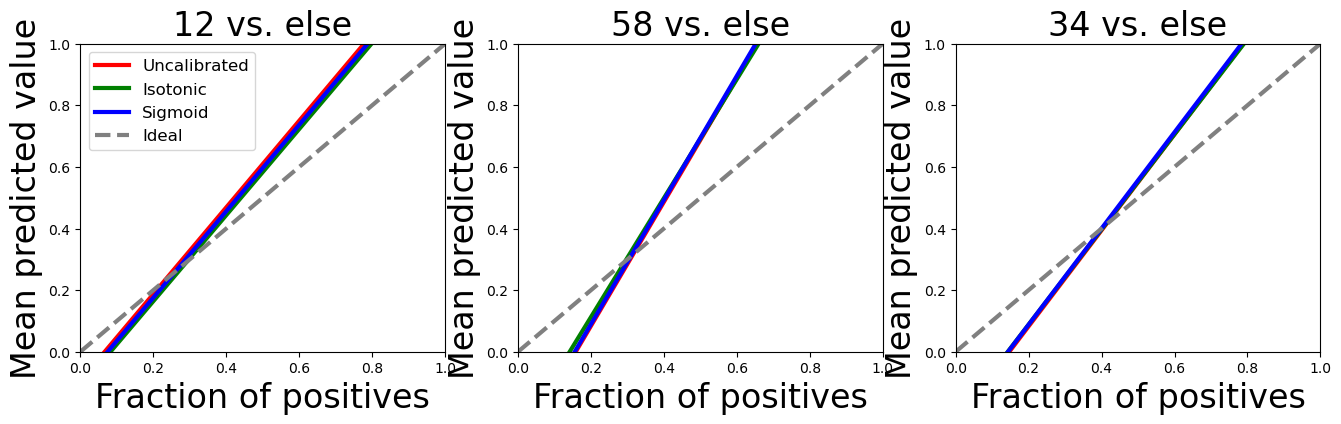

In [13]:
fig, axs = subplots(nrows=1, ncols=3, figsize=(16,4))

for i in range(3):
    for m, model in enumerate(models):
        y_pred = model.predict(X_cal)
        y_cal_b = np.vectorize(lambda x: 1 if x==i else 0)(y_cal)
        y_pred_b = np.vectorize(lambda x: 1 if x==i else 0)(y_pred)

        fop, mpv = calibration_curve(y_cal_b, (y_pred_b-y_pred_b.min())/y_pred_b.ptp(), n_bins=10)

        axs[i].plot(fop, mpv, color=colors[m], linestyle='-', linewidth=3, label=labels[m])


    axs[i].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=3, label='Ideal')
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([0, 1])
    axs[i].set_xlabel('Fraction of positives', fontsize=24)
    axs[i].set_ylabel('Mean predicted value', fontsize=24)
    axs[i].set_title(f'{classes[i]} vs. else', fontsize=24)
    
    if i==0:
        axs[i].legend(loc='best' , fontsize=12)

show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state+4)

for m, model in enumerate(models):
        model.fit(X_train, y_train)

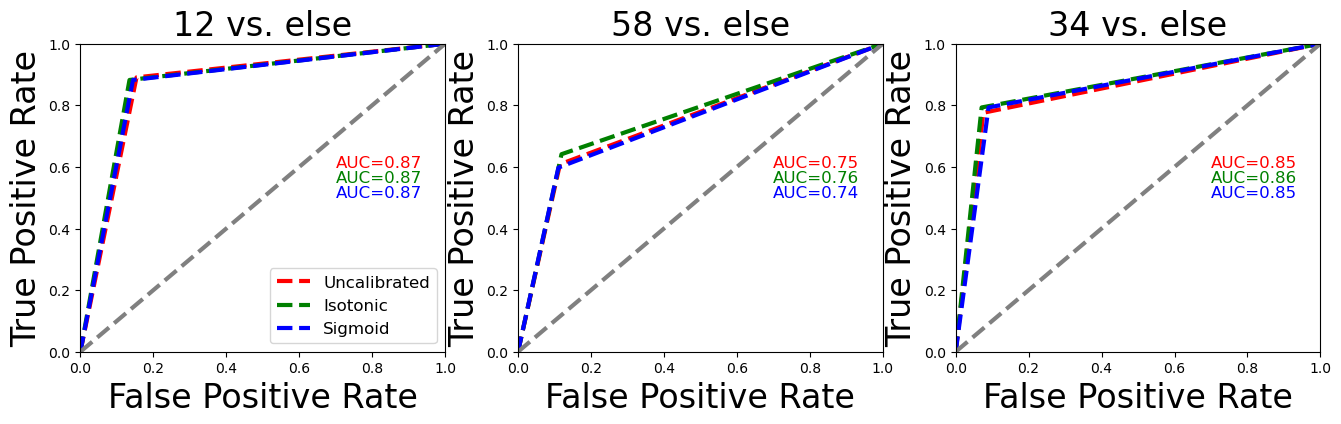

In [15]:
fig, axs = subplots(nrows=1, ncols=3, figsize=(16,4))

for i in range(3):
    for m, model in enumerate(models):
        y_pred = model.predict(X_test)
        y_test_b = np.vectorize(lambda x: 1 if x==i else 0)(y_test)
        y_pred_b = np.vectorize(lambda x: 1 if x==i else 0)(y_pred)

        fpr, tpr, thresholds = roc_curve(y_test_b, y_pred_b)

        axs[i].plot(fpr, tpr, color=colors[m], linestyle='--', linewidth=3, label=labels[m])
        axs[i].text(0.7, 0.6-0.05*m, f'AUC={auc(fpr, tpr):.2f}', color=colors[m], fontsize=12)

    axs[i].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=3)
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([0, 1])
    axs[i].set_xlabel('False Positive Rate', fontsize=24)
    axs[i].set_ylabel('True Positive Rate', fontsize=24)
    axs[i].set_title(f'{classes[i]} vs. else', fontsize=24)
    

    if i==0:
        axs[i].legend(loc='best' , fontsize=12)
            
show()

In [16]:
X = df.iloc[:,3:]
y = df['Class']

In [17]:
best_model = RandomForestClassifier(criterion='gini', max_features= 'log2', n_estimators=200)
best_model.fit(X, y)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X)

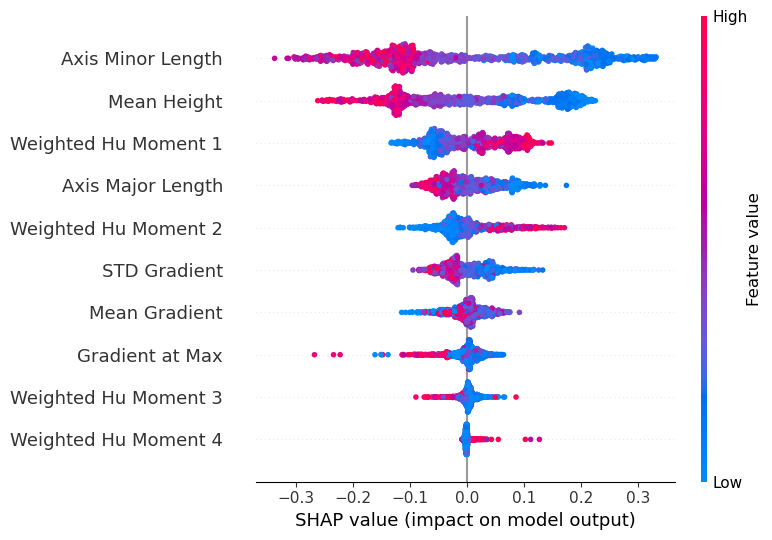

In [18]:
shap.summary_plot(shap_values[:,:,0], X, max_display=X.shape[1])

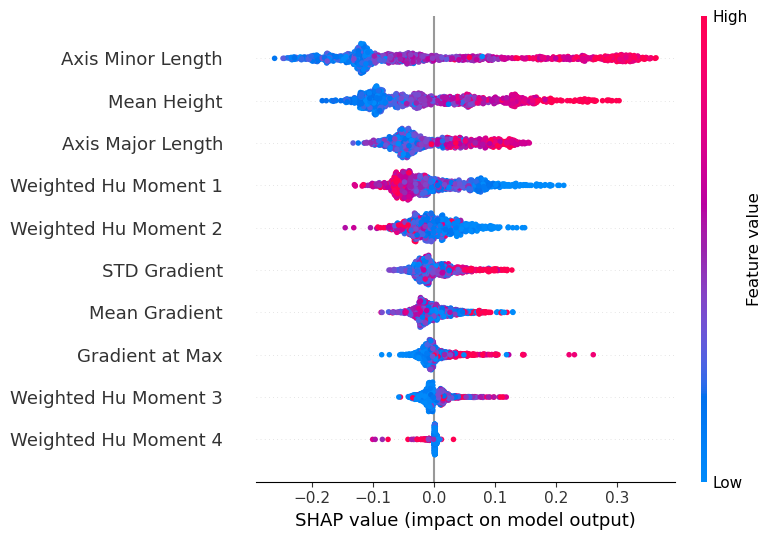

In [19]:
shap.summary_plot(shap_values[:,:,1], X, max_display=X.shape[1])

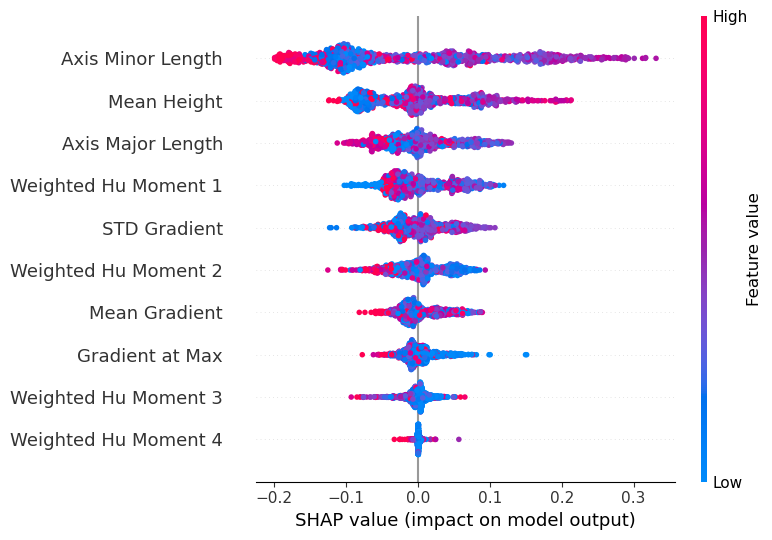

In [20]:
shap.summary_plot(shap_values[:,:,2], X, max_display=X.shape[1])

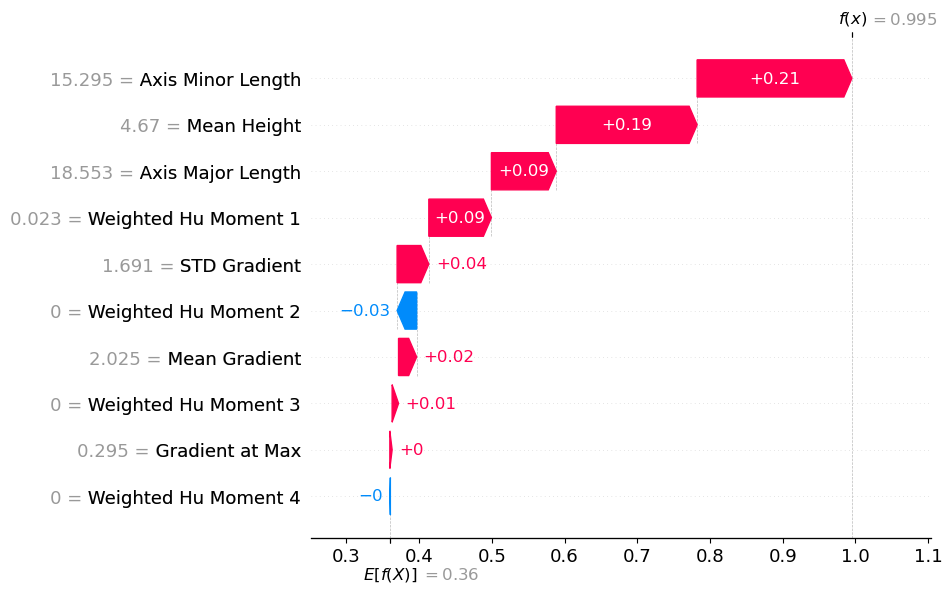

In [21]:
shap.plots.waterfall(shap_values[100,:,0])

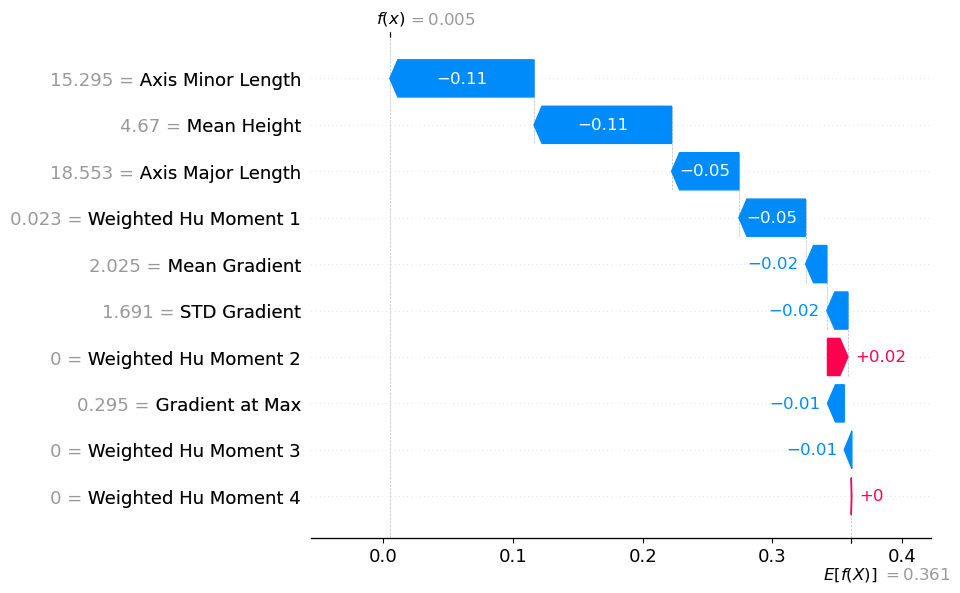

In [22]:
shap.plots.waterfall(shap_values[100,:,1])

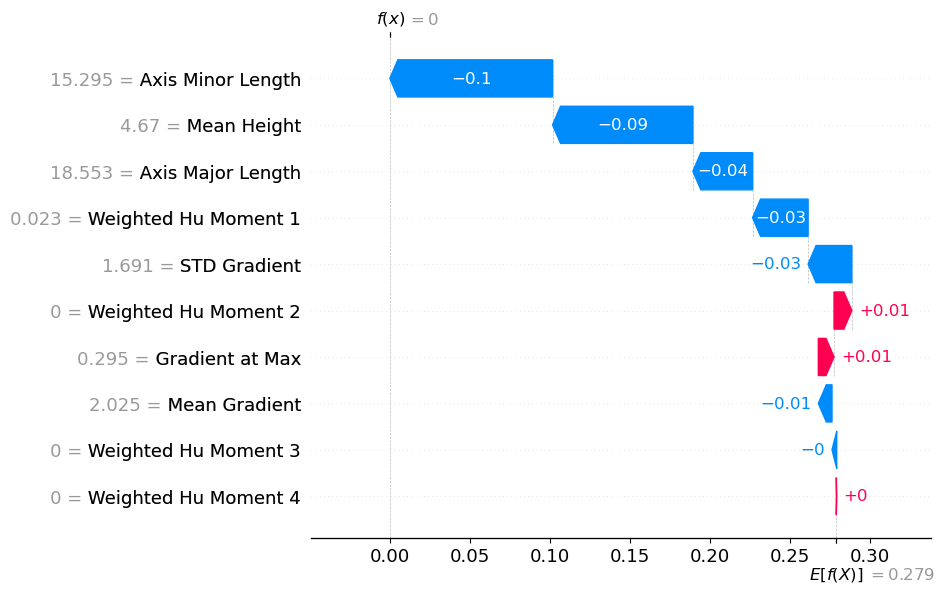

In [23]:
shap.plots.waterfall(shap_values[100,:,2])

In [24]:
X.columns

Index(['Axis Major Length', 'Axis Minor Length', 'Mean Height',
       'Mean Gradient', 'STD Gradient', 'Gradient at Max',
       'Weighted Hu Moment 1', 'Weighted Hu Moment 2', 'Weighted Hu Moment 3',
       'Weighted Hu Moment 4'],
      dtype='object')

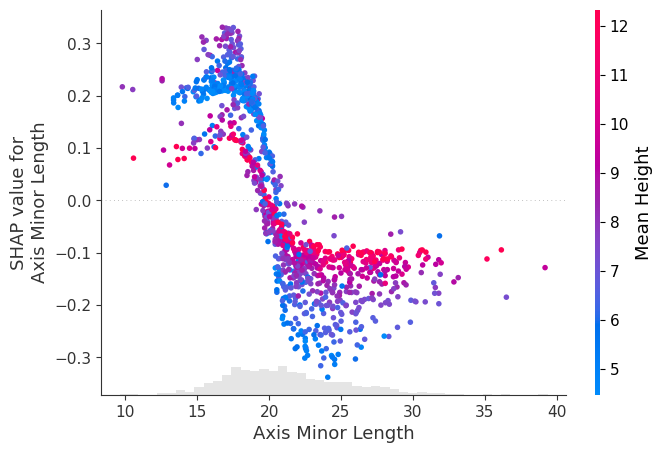

In [25]:
shap.plots.scatter(shap_values[:,1,0], color=shap_values[:,2,0])

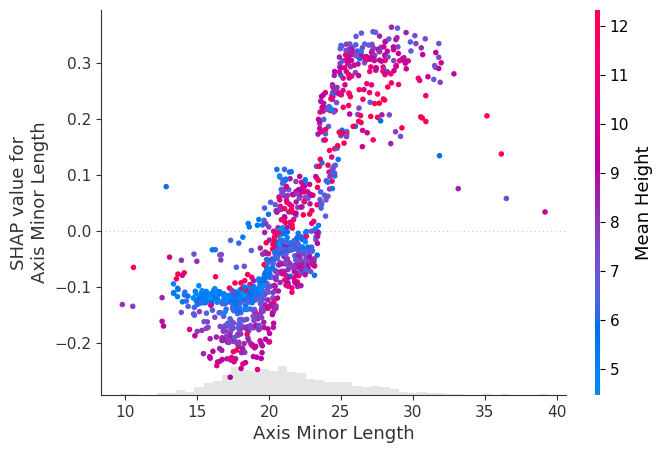

In [26]:
shap.plots.scatter(shap_values[:,1,1], color=shap_values[:,2,1])

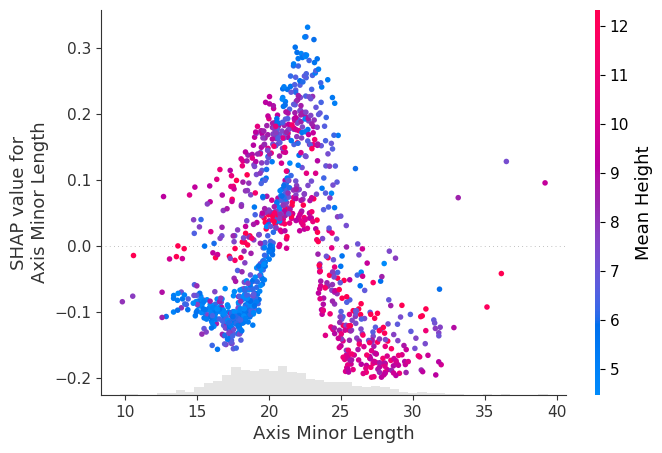

In [27]:
shap.plots.scatter(shap_values[:,1,2], color=shap_values[:,2,2])

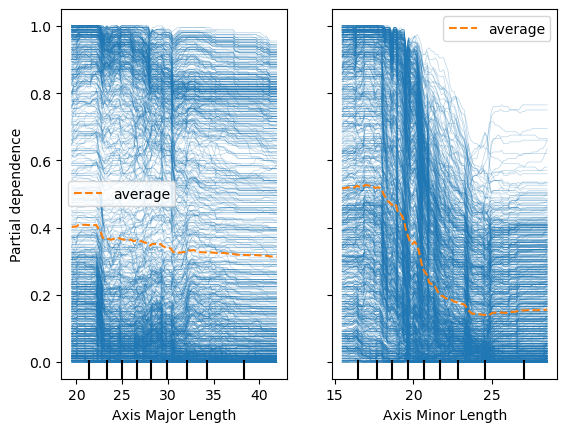

In [28]:
best_model = RandomForestClassifier(criterion='gini', max_features= 'log2', n_estimators=200)
best_model.fit(X, y)
features_PDP = ["Axis Major Length", "Axis Minor Length"]
PartialDependenceDisplay.from_estimator(best_model, X, features_PDP, kind='both', target=12)

PyALE._ALE_generic:INFO: Continuous feature detected.


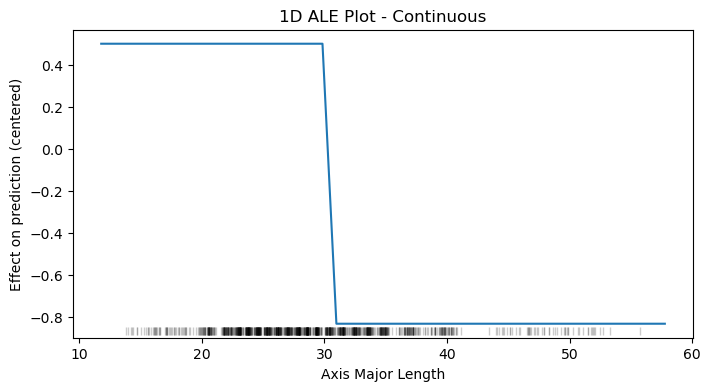

In [29]:
ale_eff = ale(X=X, model=best_model, feature=["Axis Major Length"], grid_size=20, include_CI=False)

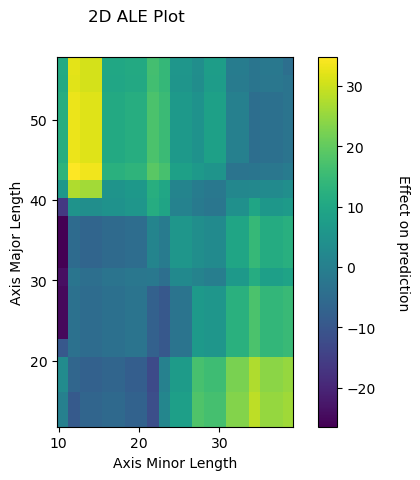

In [30]:
ale_eff = ale(X=X, model=best_model, feature=features_PDP, grid_size=20, include_CI=False)

In [31]:
explainer = lime.lime_tabular.LimeTabularExplainer(X.to_numpy(), class_names=['12', '58', '34'], feature_names = X.columns, kernel_width=2, mode='classification')

In [32]:
i = np.random.randint(0, X.shape[0])
exp = explainer.explain_instance(X.iloc[i,:], best_model.predict_proba, num_features=X.shape[1], top_labels=1)
exp.save_to_file(f'original_lime_row{i}.html')